In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt 
from torch.utils.data import TensorDataset, DataLoader

# Linear regression

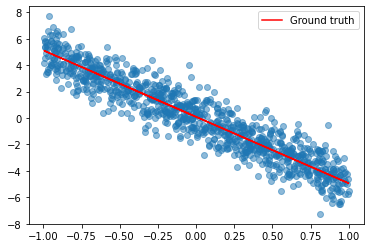

In [2]:
def generate_dataset(n, d):
    X = np.random.uniform(-1, 1, (n, d))
    one = np.ones(n)
    X = np.vstack([one, X.T]).T
    eps = np.random.normal(0, 1, n)
    beta = np.random.uniform(-10, 10, d+1)
    Y = (X @ beta) + eps
    return X, Y, beta

d = 1
n = 1000
X, Y, beta_true = generate_dataset(n, d)

if d == 1:
    plt.scatter(X[:, 1:], Y, alpha=0.5)
    plt.plot(X[:, 1:], (X @ beta_true), color='r', label='Ground truth')
    plt.legend()
    plt.show()

No handles with labels found to put in legend.


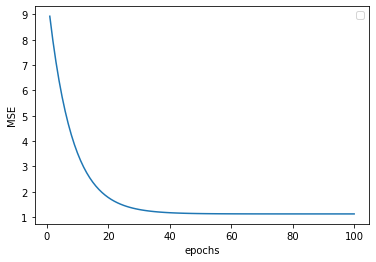

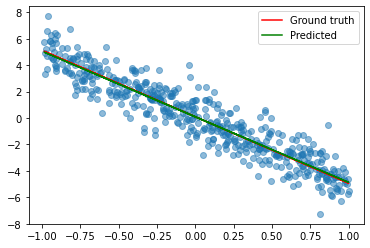

Training loss: 1.121
held-out loss 1.0011112334909078


In [3]:
def plot(X, Y, beta):
    X = X.detach().numpy()
    Y = Y.detach().numpy()
    beta = beta.detach().numpy()
    plt.scatter(X[:, 1:], Y, alpha=0.5)
    plt.plot(X[:, 1:], (X @ beta_true), color='r', label='Ground truth')
    plt.plot(X[:, 1:], (X @ beta), color='g', label='Predicted')
    plt.legend()
    plt.show()

class LinearRegressor():
    def __init__(self, d):
        self.beta = None

    def fit(self, X, Y, epochs=100, lr=0.1, verbose=False):
        n = X.shape[0]
        d = X.shape[1] - 1
        if self.beta == None:
            self.beta = torch.autograd.Variable(
                torch.zeros(d + 1), requires_grad=True)
        X_pt = torch.Tensor(X)
        Y_pt = torch.Tensor(Y)
        dataset = TensorDataset(X_pt, Y_pt)
        dataloader = DataLoader(dataset, batch_size=n) # GD
        losses = []
        for e in range(epochs):
            for X, Y in dataloader:
                Y_hat = X @ self.beta
                loss = torch.mean((Y - Y_hat) ** 2)
                loss.backward()
                with torch.no_grad():
                    dbeta = self.beta.grad
                    self.beta.add_(dbeta, alpha=-lr)
                self.beta.grad.zero_()
            losses.append(loss.detach().numpy())

        if d == 1 and verbose:
            plt.plot(np.arange(1, epochs+1), losses)
            plt.ylabel('MSE')
            plt.xlabel('epochs')
            plt.legend()
            plt.show()
            plot(X, Y, self.beta)
        print(f'Training loss: {losses[-1]:.4}')

    def predict(self, X):
        X = torch.Tensor(X)
        Y_hat = X @ self.beta
        return Y_hat.detach().numpy()

model = LinearRegressor(d)
model.fit(X[:n//2], Y[:n//2], verbose=True)
Y_hat = model.predict(X[n//2:])
print(f'held-out loss {np.mean((Y_hat - Y[n//2:])**2)}')


# Geodesic regression

In [4]:
def prepend(a, x):
    return np.concatenate(([a], x))

def validate(x, K=-1, eps=0.00001):
    """ Verifies that x is on manifold
    """
    assert(K < 0)
    assert(x[0] > 0)
    assert(-eps <= h_inner(x, x) - (1 / K) <= eps)

def h_inner(X, Y):
    return np.dot(X[1:], Y[1:]) - np.dot(X[:1], Y[:1])

def h_norm(X):
    return np.sqrt(h_inner(X, X))

def dist(X, Y, K=-1):
    return (1 / np.sqrt(-K)) * np.arccosh(-K * h_inner(X, Y))

def pt(v, nu, mu):
    validate(nu, K)
    validate(mu, K)
    R = 1 / np.sqrt(-K)
    return v + ((h_inner(mu, v) / ((R**2) - h_inner(nu, mu))) * (nu + mu))

def exp(mu, u, K=-1):
    norm = h_norm(u)
    z = (np.cosh(norm) * mu) + (np.sinh(norm) * (u / norm))
    validate(z, K)
    return z

def invexp(mu, z, K=-1):
    validate(z, K)
    alpha = -h_inner(mu, z)
    return (np.arccosh(alpha) / (np.sqrt((alpha**2) - 1))) * (z - (alpha * mu))

# Get a point in H^n 
def sample_Hn(mu=0.0, std=10.0, d=3, K=-1):
    """ TODO better way to do this? Use expmap? 
    """
    p = np.zeros(d+1)
    p[0] = 1.0
    var = std ** 2
    x = np.random.multivariate_normal(np.ones(d)*mu, np.eye(d) * var)
    x /= (np.sqrt(-K) * np.sqrt(np.dot(x, x)))
    x0 = np.sqrt((np.linalg.norm(x)**2) - (1 / K))
    x = prepend(x0, x)
    validate(x, K)
    return x

In [22]:
def generate_hyperbolic_dataset(n, d, K):
    h_origin = prepend(1, np.zeros(d))
    p = sample_Hn(d=d, K=K) # TODO There's a nicer way to sample this
    
    # Sample betas in the tangent space of the origin of Hn
    beta_To = prepend(0, np.random.uniform(-1, 1, d))
    beta_Tp = pt(beta_To, h_origin, p)
    X = np.random.uniform(-1, 1, (n, 1))

    # Get y, add noise to it
    y = [exp(p, X[i, :] * beta_Tp) for i in range(n)]
    eps_To = np.random.randn(n, d+1)
    eps_To[:, 0] *= 0.0
    eps_Ty = [pt(eps_To[i], h_origin, y[i]) for i in range(n)]
    y_eps = [exp(y[i], eps_Ty[i]) for i in range(n)]
    return X, np.array(y_eps), beta_Tp, p

n = 10
d = 2
K = -1
X, Y, beta, p = generate_hyperbolic_dataset(n, d, K)

In [23]:
def plot(X, Y, beta):
    raise NotImplementedError
    X = X.detach().numpy()
    Y = Y.detach().numpy()
    beta = beta.detach().numpy()
    plt.scatter(X[:, 1:], Y, alpha=0.5)
    plt.plot(X[:, 1:], (X @ beta_true), color='r', label='Ground truth')
    plt.plot(X[:, 1:], (X @ beta), color='g', label='Predicted')
    plt.legend()
    plt.show()

def bvalidate(z, K=-1, eps=0.001):
    assert(K < 0)
    assert(all(z[:, 0] > 0))
    assert(-eps <= min(h_inner_t(z, z) - (1 / K)) <= eps)
    assert(-eps <= max(h_inner_t(z, z) - (1 / K)) <= eps)

def h_inner_t(X, Y):
    bdot = lambda x, y: torch.einsum('bs,bs->b', x, y)
    return bdot(X[:, 1:], Y[:, 1:]) - bdot(X[:, :1], Y[:, :1])

def h_norm_t(X):
    return torch.sqrt(h_inner_t(X, X))

def dist_t(X, Y):
    bvalidate(X, K)
    bvalidate(Y, K)
    return torch.arccosh(-h_inner_t(X, Y))

def exp_t(mu, u, K=-1):
    norm = h_norm_t(u).unsqueeze(1)
    mu_rpt = mu.unsqueeze(0).repeat(norm.shape[0], 1)
    bvalidate(mu_rpt, K)
    # NOTE Gives nan ???
    z = (torch.cosh(norm) * mu_rpt) + (torch.sinh(norm) * (u / norm))
    bvalidate(z, K)
    return z

def pt_t(v, nu, mu):
    bvalidate(nu, K)
    bvalidate(mu, K)
    R = 1 / np.sqrt(-K)
    return v + ((h_inner_t(mu, v) / ((R**2) - h_inner_t(nu, mu))) * (nu + mu))

class HGeodesicRegressor():
    def __init__(self, d, K):
        self.d = d
        self.K = K
        # TODO initialize q and beta to be on manifold TODO not origin???
        h_origin = prepend(1, np.zeros(d))
        p = sample_Hn(d=d, K=K)
        # Sample betas in the tangent space of the origin of Hn
        beta_To = prepend(0, np.random.uniform(-.1, .1, d))
        beta_Tp = pt(beta_To, h_origin, p)
        #q = torch.zeros(d + 1)
        #q[0] = 1.0
        q = torch.Tensor(p)
        self.q = torch.autograd.Variable(q, requires_grad=True)
        #beta = torch.rand(d + 1)
        #beta[0] = 0.0
        beta = torch.Tensor(beta_Tp)
        self.beta = torch.autograd.Variable(beta, requires_grad=True)

    def fit(self, X, Y, epochs=1, lr=0.0, verbose=False):
        n = X.shape[0]
        d = self.d
            
        X_pt = torch.Tensor(X)
        Y_pt = torch.Tensor(Y)
        dataset = TensorDataset(X_pt, Y_pt)
        dataloader = DataLoader(dataset, batch_size=n)
        losses = []
        for e in range(epochs):
            for X, Y in dataloader:

                # TODO 
                Y_hat = exp_t(self.q, X * self.beta)
                bvalidate(Y_hat)
                bvalidate(Y)
                loss = torch.mean(dist_t(Y, Y_hat) ** 2)
                print(loss.item())

                loss.backward()
                with torch.no_grad():
                    dq = self.q.grad
                    # Apply exponential map to step in -gradient of q
                    step = -lr * dq
                    step = step.unsqueeze(0).repeat(X.shape[0], 1)
                    q_new = exp_t(self.q, step)

                    # Use vector subtraction, then parallel transport to 
                    # the updated tangent space of q
                    dbeta = self.beta.grad
                    self.beta.add_(dbeta, alpha=-lr)
                    self.beta = self.pt_t(self.beta, self.q, q_new)
                    self.q = q_new

                self.q.grad.zero_()
                self.beta.grad.zero_()
            losses.append(loss.detach().numpy())

        if d == 1 and verbose:
            raise NotImplementedError
            plt.plot(np.arange(1, epochs+1), losses)
            plt.ylabel('MSE')
            plt.xlabel('epochs')
            plt.legend()
            plt.show()
            plot(X, Y, self.beta)
        print(f'Training loss: {losses[-1]:.4}')

    def predict(self, X):
        X = torch.Tensor(X)

        # TODO implement correct prediction function
        Y_hat = exp_t(self.q, X * self.beta)

        return Y_hat.detach().numpy()

model = HGeodesicRegressor(d, K)
model.fit(X[:n//2], Y[:n//2], verbose=False)
Y_hat = model.predict(X[n//2:])
# TODO implement correct loss
#print(f'held-out loss {np.mean((Y_hat - Y[n//2:])**2)}')


3.0609705448150635


AssertionError: 